In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [3]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",")

##### Core Trading Data

* best_bid_amount, best_ask_amount: The quantity available at the best bid and best ask prices.
* best_bid_price, best_ask_price: The highest price buyers are willing to pay (bid) and the lowest price sellers are willing to accept (ask).
* bid_iv, ask_iv: Implied volatility of the best bid and ask.
* underlying_index: The index or ticker symbol of the underlying asset, which in this case is Bitcoin.
* underlying_price: Current price of the underlying asset.
* mark_iv: The market's consensus on implied volatility.
* open_interest: Total number of outstanding derivative contracts, such as options or futures, that have not been settled.
* max_price, min_price: Maximum and minimum prices recorded.
* last_price: The most recent price at which the option was traded.

##### Advanced Trading Metrics
* interest_rate: Interest rate used for pricing options, typically a risk-free rate.
* asks, bids: These might contain more detailed order book data in JSON or another structured format.
* settlement_price: The price used for settling trades at the end of a trading period.
* mark_price: The current market price of the contracts.
* index_price: Index price that the derivative tracks.

##### Timestamps and Changes
* change_id: An identifier for tracking changes to data points.
* timestamp: UNIX timestamp indicating the time of data retrieval.


##### Greeks
* greeks.rho: Sensitivity to the interest rate.
* greeks.theta: Sensitivity to time decay.
* greeks.vega: Sensitivity to changes in the volatility of the underlying asset.
* greeks.gamma: The rate of change of delta with respect to changes in the underlying price.
* greeks.delta: The rate of change of the option's price with respect to changes in the underlying asset's price.

##### Statistical Data
* stats.volume_usd, stats.volume: Trading volume in USD and in units.
* stats.price_change, stats.low, stats.high: Change in price, lowest, and highest price during the recording period.

##### Settlement Information
* settlement_period: The periodicity of settlement, such as daily, weekly, etc.

### Data Cleaning and Preparation

### Bitcoin

In [37]:
df.head()

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,best_bid_price,best_ask_price,open_interest,...,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high,settlement_period
0,0.0,0.0,0.0,0.00,BTC-3MAY24,59330.12,100.0,0.0,0.0000,125.0,...,0.0,0.0,0.0,1.0,402682.41,18.0,0.0000,0.3850,0.3850,week
1,0.0,10.0,0.0,0.00,BTC-3MAY24,59330.12,100.0,0.0,0.0001,22.0,...,0.0,0.0,0.0,0.0,4.74,0.8,0.0000,0.0001,0.0001,week
2,0.0,0.0,0.0,0.00,BTC-3MAY24,59329.29,100.0,0.0,0.0000,31.0,...,0.0,0.0,0.0,1.0,277903.56,16.0,-6.6667,0.2800,0.3000,week
3,0.0,13.4,0.0,513.66,BTC-3MAY24,59329.29,100.0,0.0,0.0001,10.4,...,0.0,0.0,0.0,0.0,40.17,6.8,0.0000,0.0001,0.0001,week
4,0.0,10.0,0.0,465.65,BTC-3MAY24,59327.17,100.0,0.0,0.2425,35.0,...,0.0,0.0,0.0,1.0,209329.77,24.0,146.9136,0.0810,0.2000,week


In [38]:
df.columns

Index(['best_bid_amount', 'best_ask_amount', 'bid_iv', 'ask_iv',
       'underlying_index', 'underlying_price', 'mark_iv', 'best_bid_price',
       'best_ask_price', 'open_interest', 'max_price', 'min_price',
       'last_price', 'asks', 'bids', 'settlement_price', 'instrument_name',
       'mark_price', 'index_price', 'change_id', 'timestamp', 'greeks.rho',
       'greeks.theta', 'greeks.vega', 'greeks.gamma', 'greeks.delta',
       'stats.volume_usd', 'stats.volume', 'stats.price_change', 'stats.low',
       'stats.high', 'settlement_period'],
      dtype='object')

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   best_bid_amount     1030 non-null   float64
 1   best_ask_amount     1030 non-null   float64
 2   bid_iv              1030 non-null   float64
 3   ask_iv              1030 non-null   float64
 4   underlying_index    1030 non-null   object 
 5   underlying_price    1030 non-null   float64
 6   mark_iv             1030 non-null   float64
 7   best_bid_price      1030 non-null   float64
 8   best_ask_price      1030 non-null   float64
 9   interest_rate       1030 non-null   float64
 10  open_interest       1030 non-null   float64
 11  max_price           1030 non-null   float64
 12  min_price           1030 non-null   float64
 13  last_price          865 non-null    float64
 14  asks                1030 non-null   object 
 15  bids                1030 non-null   object 
 16  settle

In [25]:
#Get descriptive statistics
df.describe()

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_price,mark_iv,best_bid_price,best_ask_price,interest_rate,open_interest,...,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.0,1030.000000,...,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1.030000e+03,1030.000000,332.000000,332.000000,332.000000
mean,14.162621,15.911068,43.472660,75.422563,58149.553272,65.665874,0.100766,0.136121,0.0,266.396019,...,-51.949660,-30.223341,58.935529,0.000028,-0.064213,9.653280e+04,17.632136,29.360479,0.139946,0.167063
std,37.686657,22.799978,60.996398,89.657591,564.270679,18.487659,0.213953,0.251534,0.0,462.862537,...,212.133578,41.542401,63.773899,0.000078,0.618692,8.544314e+05,132.064738,344.325282,0.285782,0.308097
min,0.000000,0.000000,0.000000,0.000000,57432.360000,5.000000,0.000000,0.000000,0.0,0.000000,...,-1783.022520,-298.485950,0.000000,0.000000,-1.000000,0.000000e+00,0.000000,-99.218800,0.000100,0.000100
25%,0.000000,0.000000,0.000000,49.852500,57804.496525,57.742500,0.000000,0.000000,0.0,0.000000,...,-40.361832,-31.920412,6.520657,0.000000,-0.636540,0.000000e+00,0.000000,-1.125725,0.007475,0.011875
50%,2.750000,7.500000,52.480000,62.590000,58084.830000,64.100000,0.006250,0.024500,0.0,28.400000,...,0.000000,-21.219090,33.232840,0.000010,0.000000,0.000000e+00,0.000000,0.000000,0.039000,0.057500
75%,15.350000,19.000000,61.880000,76.727500,58296.407500,73.640000,0.104125,0.154750,0.0,379.500000,...,18.683658,-7.016243,97.286400,0.000020,0.362862,2.362053e+03,2.650000,0.000000,0.129625,0.178625
max,1000.000000,144.300000,999.000000,664.840000,59351.460000,100.000000,1.787500,1.967000,0.0,4638.300000,...,216.027820,0.000000,223.188420,0.001290,1.000000,1.571608e+07,3130.600000,5900.000000,2.132500,2.412700


In [26]:
df.isnull().sum()

best_bid_amount         0
best_ask_amount         0
bid_iv                  0
ask_iv                  0
underlying_index        0
underlying_price        0
mark_iv                 0
best_bid_price          0
best_ask_price          0
interest_rate           0
open_interest           0
max_price               0
min_price               0
last_price            165
asks                    0
bids                    0
settlement_price       40
instrument_name         0
mark_price              0
index_price             0
change_id               0
timestamp               0
greeks.rho              0
greeks.theta            0
greeks.vega             0
greeks.gamma            0
greeks.delta            0
stats.volume_usd        0
stats.volume            0
stats.price_change    698
stats.low             698
stats.high            698
settlement_period       0
dtype: int64

In [12]:
# Convert UNIX timestamps to datetime format if needed
if df['timestamp'].dtype == 'int64':
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 56306-09-14 00:11:32

In [27]:
btc_data_key= df
key_metrics = ['best_bid_price', 'best_ask_price', 'bid_iv', 'ask_iv', 'mark_iv', 
               'greeks.theta', 'greeks.vega', 'greeks.gamma', 'greeks.delta']

descriptive_stats = btc_data_key[key_metrics].describe()

# Additionally, calculate the interquartile range (IQR) to identify potential outliers
Q1 = df[key_metrics].quantile(0.25)
Q3 = df[key_metrics].quantile(0.75)
IQR = Q3 - Q1

descriptive_stats, IQR

(       best_bid_price  best_ask_price       bid_iv       ask_iv      mark_iv  \
 count     1030.000000     1030.000000  1030.000000  1030.000000  1030.000000   
 mean         0.100766        0.136121    43.472660    75.422563    65.665874   
 std          0.213953        0.251534    60.996398    89.657591    18.487659   
 min          0.000000        0.000000     0.000000     0.000000     5.000000   
 25%          0.000000        0.000000     0.000000    49.852500    57.742500   
 50%          0.006250        0.024500    52.480000    62.590000    64.100000   
 75%          0.104125        0.154750    61.880000    76.727500    73.640000   
 max          1.787500        1.967000   999.000000   664.840000   100.000000   
 
        greeks.theta  greeks.vega  greeks.gamma  greeks.delta  
 count   1030.000000  1030.000000   1030.000000   1030.000000  
 mean     -30.223341    58.935529      0.000028     -0.064213  
 std       41.542401    63.773899      0.000078      0.618692  
 min     -298

In [28]:
btc_data_key.describe 

<bound method NDFrame.describe of       best_bid_amount  best_ask_amount  bid_iv  ask_iv underlying_index  \
0                 0.0              0.0     0.0    0.00       BTC-3MAY24   
1                 0.0             10.0     0.0    0.00       BTC-3MAY24   
2                 0.0              0.0     0.0    0.00       BTC-3MAY24   
3                 0.0             13.4     0.0  513.66       BTC-3MAY24   
4                 0.0             10.0     0.0  465.65       BTC-3MAY24   
...               ...              ...     ...     ...              ...   
1025              0.0              0.0     0.0    0.00      BTC-28MAR25   
1026              0.0              0.0     0.0    0.00      BTC-28MAR25   
1027            100.0              0.0     0.0    0.00      BTC-28MAR25   
1028              0.0              0.0     0.0    0.00      BTC-28MAR25   
1029              0.0              0.0     0.0    0.00      BTC-28MAR25   

      underlying_price  mark_iv  best_bid_price  best_ask_price  

In [17]:
df.head()

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_index,underlying_price,mark_iv,best_bid_price,best_ask_price,interest_rate,...,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high,settlement_period
0,0.0,0.0,0.0,0.00,BTC-3MAY24,59330.12,100.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,1.0,402682.41,18.0,0.0000,0.3850,0.3850,week
1,0.0,10.0,0.0,0.00,BTC-3MAY24,59330.12,100.0,0.0,0.0001,0.0,...,0.0,0.0,0.0,0.0,4.74,0.8,0.0000,0.0001,0.0001,week
2,0.0,0.0,0.0,0.00,BTC-3MAY24,59329.29,100.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,1.0,277903.56,16.0,-6.6667,0.2800,0.3000,week
3,0.0,13.4,0.0,513.66,BTC-3MAY24,59329.29,100.0,0.0,0.0001,0.0,...,0.0,0.0,0.0,0.0,40.17,6.8,0.0000,0.0001,0.0001,week
4,0.0,10.0,0.0,465.65,BTC-3MAY24,59327.17,100.0,0.0,0.2425,0.0,...,0.0,0.0,0.0,1.0,209329.77,24.0,146.9136,0.0810,0.2000,week


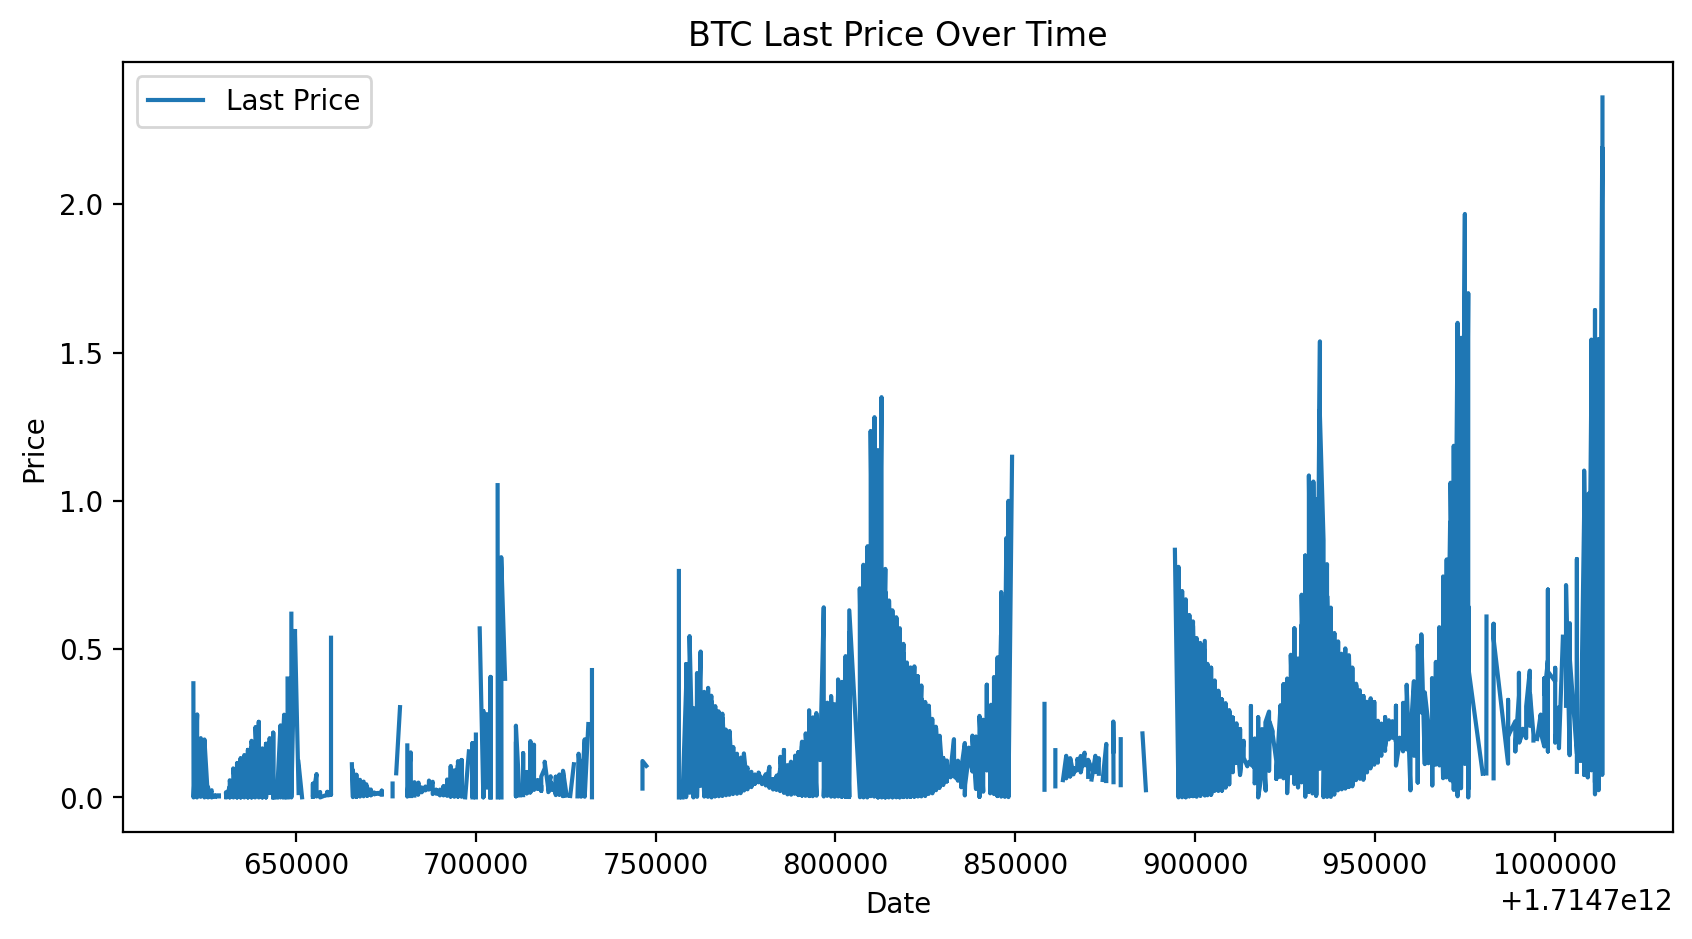

ValueError: could not convert string to float: 'BTC-3MAY24'

<Figure size 1000x800 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the closing price over time
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['last_price'], label='Last Price')
plt.title('BTC Last Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


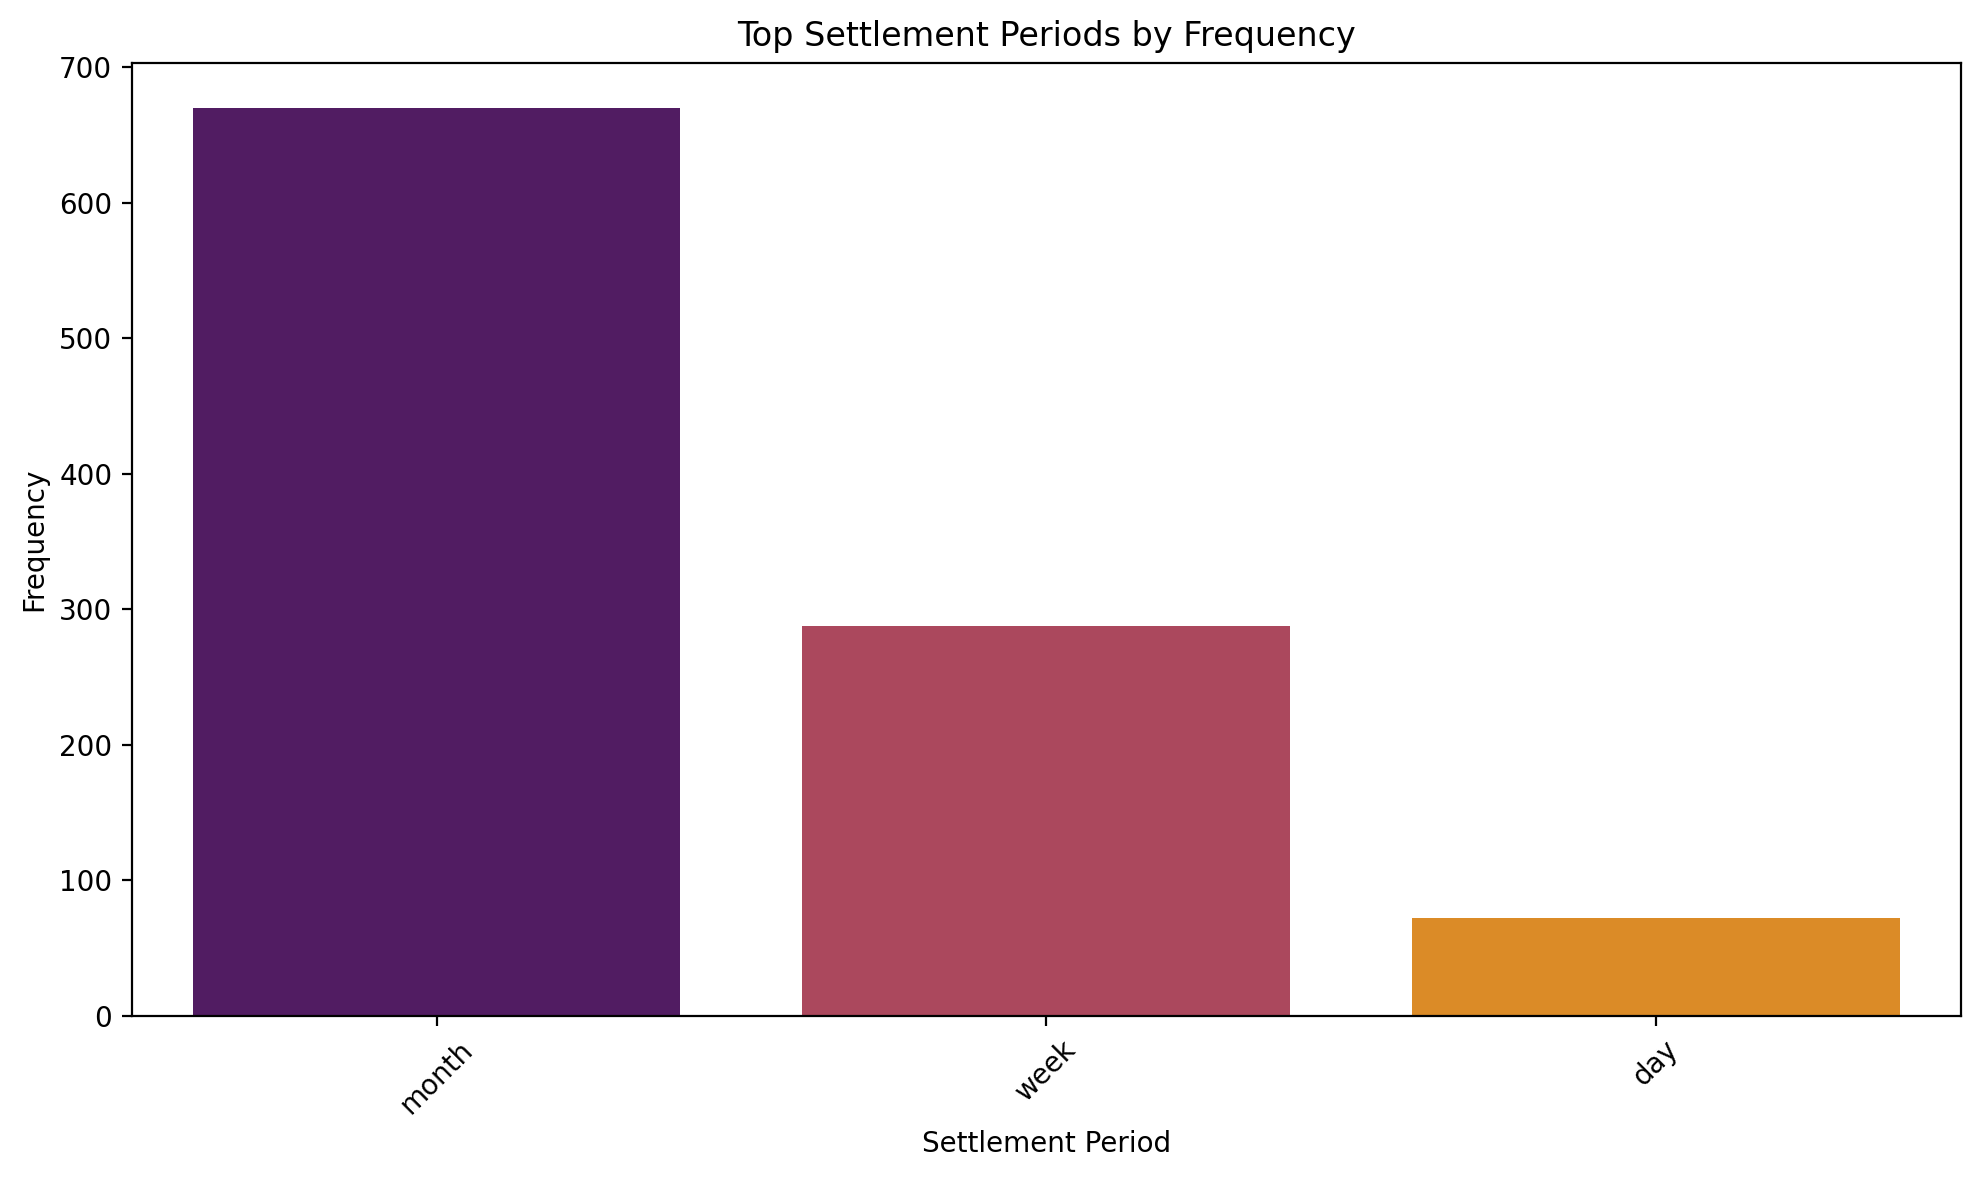

In [29]:
# Compute the frequency of each unique settlement period
btc_settlement_freq = df['settlement_period'].value_counts().reset_index()
btc_settlement_freq.columns = ['settlement_period', 'Frequency']  # Renaming columns appropriately

# Creating a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='settlement_period', y='Frequency', data=btc_settlement_freq, palette="inferno")
plt.xticks(rotation=45)
plt.xlabel('Settlement Period')
plt.ylabel('Frequency')
plt.title('Top Settlement Periods by Frequency')
plt.tight_layout()
plt.show()

### Distribution 

In [30]:
ir=df['interest_rate']
ir.describe()

count    1030.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: interest_rate, dtype: float64

## Correlation

In [35]:
import pandas as pd
import numpy as np

num_data = df.select_dtypes(include=['int64', 'float64'])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_price,mark_iv,best_bid_price,best_ask_price,open_interest,max_price,min_price,last_price,settlement_price,mark_price,index_price,change_id,timestamp,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
best_bid_amount,1.000000,0.272543,0.014559,-0.011954,0.034158,-0.055853,0.045808,0.085703,0.037725,0.014612,-0.005632,-0.009563,-0.004528,-0.016192,0.097655,0.039849,-0.119664,0.032766,-0.184346,-0.146322,0.042671,0.009243,0.015931,0.018107,-0.024624,0.088392,0.066286
best_ask_amount,0.272543,1.000000,0.003644,0.091215,0.180338,-0.184907,0.067065,0.202010,0.007295,0.054128,-0.044528,-0.063962,-0.015114,-0.031592,0.273358,0.074072,-0.340396,0.026556,-0.296572,-0.276277,0.120102,-0.155406,-0.011891,0.054300,-0.042284,-0.070283,-0.084860
bid_iv,0.014559,0.003644,1.000000,-0.119055,-0.058624,-0.138004,0.037531,-0.061777,0.056681,-0.149284,-0.147279,-0.097303,-0.180109,-0.157930,-0.014961,0.075157,-0.008077,0.088139,-0.081310,-0.025548,0.016141,0.124410,0.487974,0.554886,0.011028,-0.059635,0.035974
ask_iv,-0.011954,0.091215,-0.119055,1.000000,0.307028,0.305881,-0.027171,0.142988,0.035149,-0.166477,-0.120897,-0.124477,-0.133431,-0.132225,0.368757,0.088751,-0.401486,0.121175,0.139656,-0.347766,-0.097729,-0.039555,-0.068284,-0.055495,0.164752,-0.130307,-0.155935
underlying_price,0.034158,0.180338,-0.058624,0.307028,1.000000,0.090441,-0.250090,-0.214028,-0.130046,-0.020514,-0.150854,-0.142954,-0.116553,-0.152672,0.516460,-0.081639,-0.610695,0.042923,-0.272998,-0.296734,0.211076,-0.050469,0.093844,0.161835,0.072596,-0.167070,-0.148294
mark_iv,-0.055853,-0.184907,-0.138004,0.305881,0.090441,1.000000,0.012272,0.132110,-0.093063,0.161993,0.250512,0.240849,0.238205,0.245483,0.053311,0.072454,0.079763,-0.069214,0.226428,-0.033428,-0.439793,-0.082540,-0.047736,-0.165896,0.072408,0.210313,0.189890
best_bid_price,0.045808,0.067065,0.037531,-0.027171,-0.250090,0.012272,1.000000,0.667777,0.061480,0.459902,0.463080,0.470482,0.471835,0.485546,-0.209857,0.049931,0.252356,-0.350421,0.096584,0.102894,-0.079548,-0.145842,-0.000382,-0.048572,-0.030210,0.466249,0.441105
best_ask_price,0.085703,0.202010,-0.061777,0.142988,-0.214028,0.132110,0.667777,1.000000,0.063920,0.554909,0.588629,0.597627,0.602842,0.600400,-0.115452,0.057432,0.187072,-0.308634,0.159160,-0.014894,-0.113433,-0.182082,-0.017352,-0.059204,-0.023118,0.601626,0.557184
open_interest,0.037725,0.007295,0.056681,0.035149,-0.130046,-0.093063,0.061480,0.063920,1.000000,-0.136198,-0.057678,-0.082254,-0.083174,-0.074600,0.036401,0.061071,0.012626,0.071618,0.165880,-0.110186,-0.069989,0.016939,-0.027687,-0.019316,0.005135,-0.043281,-0.062479
max_price,0.014612,0.054128,-0.149284,-0.166477,-0.020514,0.161993,0.459902,0.554909,-0.136198,1.000000,0.919373,0.898553,0.954717,0.952191,-0.206813,-0.069002,0.250077,-0.723589,0.021779,0.118461,-0.046615,-0.399419,0.213014,-0.000857,-0.062552,0.897261,0.893357
